# AMPS to Zarr 

The Plan (outline)
- read in (some, many?) NetCDF files
- strip unneccessary variables
- squeeze time dimension from non-varying 2D fields
- write (and later append) to zarr in GCS


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
import fsspec

xr.set_options(display_style="html");
# xr.show_versions()

In [ ]:
from dask.distributed import Client, progress, LocalCluster
import numcodecs

cluster = LocalCluster()
cluster

In [ ]:
client = Client(cluster)

In [ ]:
numcodecs.blosc.use_threads = False

## dirs etc

In [2]:
gcsdir = '/Users/dporter/data/Antarctic/'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'wrfout_d03_20161222_week'
filepattern = 'wrfout_*'

pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

/Users/dporter/data/Antarctic/AMPS/WRF_24/wrfout_d03_20161222_week/wrfout_*


In [3]:
NCs = glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 56 wrf files.

/Users/dporter/data/Antarctic/AMPS/WRF_24/wrfout_d03_20161222_week/wrfout_d03_2016122512_f006.nc


In [4]:
NCs_urls = NCs

In [5]:
ds = xr.open_dataset(NCs_urls[0], engine='netcdf4', chunks={'south_north': 500, 'west_east': 270})

In [6]:
print(type(ds.T2.data))
print(ds.T2.chunks)

<class 'dask.array.core.Array'>
((1,), (500, 325), (270, 267))


In [7]:
ds.T2

<xarray.DataArray 'T2' (Time: 1, south_north: 825, west_east: 537)>
dask.array<open_dataset-7bf2007cc141ceec5fe0a794a899d4ebT2, shape=(1, 825, 537), dtype=float32, chunksize=(1, 500, 270), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 500, 270), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 500, 270), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

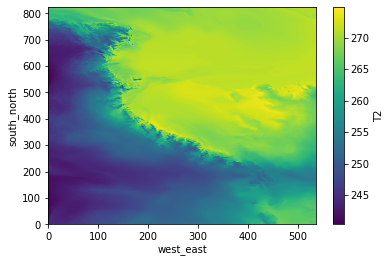

In [8]:
ds['T2'].mean(dim='Time').plot()

In [9]:
with  fsspec.open(NCs_urls[0], mode='rb')  as openfile:  
    ds = xr.open_dataset(openfile, engine='h5netcdf', 
                         chunks={'south_north': -1, 'west_east': -1, 'Time': 1})  # , decode_coords=False
    
for i in tqdm(range(1, len(NCs_urls))):  
    with  fsspec.open(NCs_urls[i], mode='rb')  as openfile:  
        temp = xr.open_dataset(openfile, engine='h5netcdf', 
                               chunks={'south_north': -1, 'west_east': -1, 'Time': 1})  
    ds = xr.concat([ds,temp],'Time')
    
ds.T2

100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


<xarray.DataArray 'T2' (Time: 56, south_north: 825, west_east: 537)>
dask.array<concatenate, shape=(56, 825, 537), dtype=float32, chunksize=(1, 825, 537), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 825, 537), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 825, 537), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    [104]
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

In [11]:
print(ds.nbytes / 1e9)

94.89125268


In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
# from tqdm.autonotebook import tqdm
import fsspec

import xarray as xr

xr.set_options(display_style="html");
# xr.show_versions()

In [8]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

### a single URL

In [11]:
openfile = fs.open(f'gs://{NCs[0]}', mode='rb') 
ds = xr.open_dataset(openfile, engine='h5netcdf', chunks={'south_north': -1, 'west_east': -1})

In [12]:
# print(type(ds))
# print(ds.T2.chunks)

# print(ds.coords)

# # ds.T2.mean().compute()
# # ds.T2.plot()

### Loop through list of URLs

In [13]:
NCs_urls = ['gs://' + x + '#mode=bytes' for x in NCs]
print(NCs_urls[0])


openfile = fs.open(NCs_urls[0], mode='rb') 
ds = xr.open_dataset(openfile, engine='h5netcdf',chunks={'south_north': -1, 
                                                               'west_east': -1,
                                                               'Time': -1})
for i in tqdm(range(1, len(NCs_urls))):
    openfile = fs.open(NCs_urls[i], mode='rb') 
    temp = xr.open_dataset(openfile, engine='h5netcdf',chunks={'south_north': -1, 
                                                               'west_east': -1,
                                                               'Time': -1})
    ds = xr.concat([ds,temp],'Time')

    

gs://ldeo-glaciology/AMPS/WRF_24/wrfout_d03_2019093000_f003.nc#mode=bytes


100%|██████████| 7/7 [00:17<00:00,  2.55s/it]


In [19]:
print(f"Total size for {ds.DX[0]/1000:.2f} km output: {ds.nbytes / 1e9:.3f} Gb\n")
ds.T2

Total size for 2.67 km output: 21.443 Gb



<xarray.DataArray 'T2' (Time: 8, south_north: 1035, west_east: 675)>
dask.array<concatenate, shape=(8, 1035, 675), dtype=float32, chunksize=(1, 1035, 675), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    [104]
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

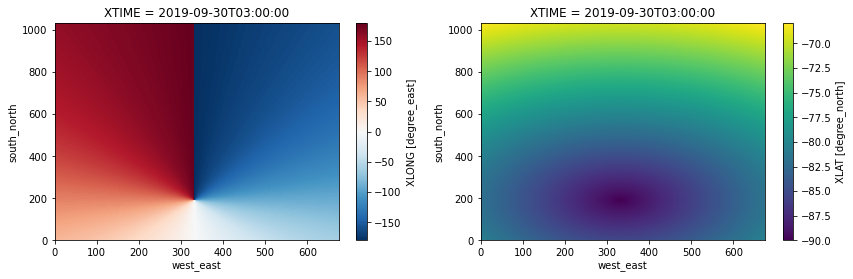

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
ds.coords['XLONG'].isel(Time=0).plot(ax=ax1)
ds.coords['XLAT'].isel(Time=0).plot(ax=ax2)

In [14]:
ds.coords['XTIME'].compute()

<xarray.DataArray 'XTIME' (Time: 8)>
array(['2019-09-30T03:00:00.000000000', '2019-09-30T06:00:00.000000000',
       '2019-09-30T09:00:00.000000000', '2019-09-30T12:00:00.000000000',
       '2019-09-30T15:00:00.000000000', '2019-09-30T18:00:00.000000000',
       '2019-09-30T21:00:00.000000000', '2019-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    XTIME    (Time) datetime64[ns] 2019-09-30T03:00:00 ... 2019-10-01
Dimensions without coordinates: Time
Attributes:
    FieldType:    [104]
    MemoryOrder:  0  
    description:  minutes since 2019-09-30 00:00:00
    stagger:

## REchunk

this looks cool but can be very inefficient

In [21]:
ds = ds.chunk({"Time": -1})
ds.T2

# ds.T2.mean(dim='Time').plot()
# ds.PSFC.mean().compute()

<xarray.DataArray 'T2' (Time: 8, south_north: 1035, west_east: 675)>
dask.array<rechunk-merge, shape=(8, 1035, 675), dtype=float32, chunksize=(8, 1035, 675), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(8, 1035, 675), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(8, 1035, 675), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(8,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    [104]
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

## Some pretty plots

## Alternatively using `open_mfdatasets`

Build list of URLs to public data in the bucket

### pre-process to deal with time

In [46]:
### GENERIC
def rename_timecoord(ds): 
#     .assign_coords(lat=ds.coords['XLAT'].squeeze('XTIME'), lon=ds.coords['XLONG'].squeeze('XTIME'))
    return ds.swap_dims({'Time':'XTIME'}) # .assign_coords(lat=ds_geo.coords['XLAT'].squeeze('Time'), lon=ds_geo.coords['XLONG'].squeeze('Time'))
    
### DROP NON TIME COORDS
# def non_time_coords(ds):
#     return [v for v in ds.data_vars
#             if 'Time' not in ds[v].dims]

# def drop_non_essential_vars_pop(ds):
#     return ds.drop(non_time_coords(ds))   

# ### DROP SOME COORDS
# def drop_coords(ds):
#     ds = ds.drop(['reference_time','feature_id', 'crs'])
#     return ds.reset_coords(drop=True)

# ### TEST ADDING TIME
# def add_time_dim(xda):
#     from datetime import datetime
    
#     xda = xda.expand_dims(Time = [datetime.now()])
#     return xda

In [47]:
%%time
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs] # needed for open_mfdataset

ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,  
                       preprocess = rename_timecoord,
                       decode_cf=False,
#                        chunks={'XTIME': -1},
                       ).swap_dims({'XTIME':'Time'}).chunk({"Time": -1})

CPU times: user 7.66 s, sys: 3.48 s, total: 11.1 s
Wall time: 3min 17s


In [18]:
# # this runs almost instantly  (from RABERNAT)
# ds = xr.open_mfdataset(NCs_urls, decode_times=False, chunks={'Time': 1},
#                        preprocess=drop_non_essential_vars_pop, decode_cf=False)

In [19]:
%%time
ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,   
                       concat_dim='Time', data_vars='minimal', coords='minimal', compat='override',
#                        combine='by_coords', 
#                        chunks={'Time': -1},
                       preprocess = rename_timecoord,
                      )

CPU times: user 486 ms, sys: 11.3 ms, total: 497 ms
Wall time: 51.2 s


In [ ]:
print(ds.U)

In [38]:
%%time
# ds.T2.chunk({"XTIME": -1}).mean().compute()
ds.T2.mean().compute()

# print(ds['T2'].shape)
# print(ds.var)

CPU times: user 204 ms, sys: 136 ms, total: 340 ms
Wall time: 4.5 s


<xarray.DataArray 'T2' ()>
array(239.92863, dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 2019-09-30T03:00:00

## Test write to zarr

To Do before writing to Zarr
- squeeze "Time" from all 2D fields
- trim fields


In [ ]:
ds.coords['XLAT_U'].nbytes/1e6

In [ ]:
# ds.coords['XLAT'] = ds.XLAT.isel(Time=0)
ds.coords['XLAT'] = ds.XLAT.isel(Time=0)
ds

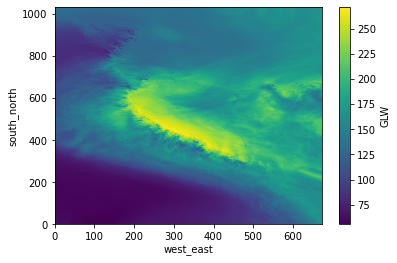

In [35]:
ds.GLW.mean(dim='Time').plot()
# ds.U.nbytes/1e6

In [ ]:
# U 34 0 x-wind component (m s-1)
# V 34 0 y-wind component (m s-1)
# W 34 0 z-wind component (m s-1)
# PH 34 0 perturbation geopotential (m2 s-2)
# PHB 34 0 base-state geopotential (m2 s-2)
# T 34 0 perturbation potential temperature (theta-t0) (K)

# P 34 0 perturbation pressure (Pa)
# PB 34 0 BASE STATE PRESSURE (Pa)
# P_HYD 34 0 hydrostatic pressure (Pa)
# Q2 1 0 QV at 2 M (kg kg-1)
# T2 1 0 TEMP at 2 M (K)

# PSFC 1 0 SFC PRESSURE (Pa)
# U10 1 0 U at 10 M (m s-1)
# V10 1 0 V at 10 M (m s-1)
# QVAPOR 34 0 Water vapor mixing ratio (kg kg-1)
# QCLOUD 34 0 Cloud water mixing ratio (kg kg-1)
# QRAIN 34 0 Rain water mixing ratio (kg kg-1)
# QICE 34 0 Ice mixing ratio (kg kg-1)
# QSNOW 34 0 Snow mixing ratio (kg kg-1)
# QGRAUP 34 0 Graupel mixing ratio (kg kg-1)
# QNICE 34 0 Ice Number concentration ( kg-1)
# QNSNOW 34 0 Snow Number concentration ( kg(-1))
# QNRAIN 34 0 Rain Number concentration ( kg(-1))
# QNGRAUPEL 34 0 Graupel Number concentration ( kg(-1))
# LANDMASK 1 0 LAND MASK (1 FOR LAND, 0 FOR WATER) (-)

# SST 1 0 SEA SURFACE TEMPERATURE (K)
# SSTSK 1 0 SKIN SEA SURFACE TEMPERATURE (K)

# TSK 1 0 SURFACE SKIN TEMPERATURE (K)
# RAINC 1 0 ACCUMULATED TOTAL CUMULUS PRECIPITATION (mm)
# RAINSH 1 0 ACCUMULATED SHALLOW CUMULUS PRECIPITATION (mm)
# RAINNC 1 0 ACCUMULATED TOTAL GRID SCALE PRECIPITATION (mm)

# QFX 1 0 UPWARD MOISTURE FLUX AT THE SURFACE (kg m-2 s-1)

In [27]:
vars_save = ['U', 'V', 'W', 'PH', 'PHB', 'T', 'P', 'PB',
             'P_HYD', 'Q2', 'T2', 'PSFC', 'U10', 'V10',
             'QVAPOR', 'QICE', 'QCLOUD', 'QRAIN', 'QSNOW', 'QGRAUP', 
             'LANDMASK', 'HGT',
             'SST', 'SSTSK', 'TSK',
             'RAINC', 'RAINSH', 'RAINNC', 
             'QFX', 'HFX', 'LH', 'PBLH', 'ACSNOM', 'SWDOWN', 'LWDNB', 'GLW',
            'SNOW', 'SNOWH']

In [7]:
outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-raw/')
# fs.glob(outdir)
fsspec.ls(outdir)

AttributeError: module 'fsspec' has no attribute 'ls'

In [12]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'wrfout_d03_201909.zarr', mode='ab',
                            token=token)

In [ ]:
%%time
ds.to_zarr(amps_mapper, mode='w');

CPU times: user 6.48 s, sys: 594 ms, total: 7.07 s
Wall time: 8min 56s

## Close your cluster, be a good denizen.

In [36]:
cluster.shutdown()